In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [ ]:
!pip install contractions
!pip install swifter

In [37]:
submissions = "/content/drive/MyDrive/WSB/WSB_submissions_with_sentiment.csv"
df_submissions = pd.read_csv(submissions, delimiter=";")
df_submissions.head()

,created_utc,author,created_utc.1,id,link_flair_text,num_comments,score,subreddit_subscribers,selftext,title,upvote_ratio,url,title_polarity,title_subjectivity,body_polarity,body_subjectivity,polarity
0,2021-10-19 17:58:57,VendiVendiVendi,2021-10-19 17:58:57,qbh10s,Gain,0,1,10967090,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,BB,1.0,https://www.reddit.com/r/wallstreetbets/comments/qbh10s/bb/,0.0,0.000000,-0.470378,0.516667,-0.470378
1,2021-10-19 17:57:49,Far_Bass_7284,2021-10-19 17:57:49,qbh04w,News,1,1,10967087,NaN,Surely it is a coincidence.,1.0,https://www.reddit.com/gallery/qbh04w,0.5,0.888889,0.000000,0.000000,0.500000
2,2021-10-19 17:55:24,HistoricalAnimator43,2021-10-19 17:55:24,qbgyco,YOLO,0,1,10967076,NaN,yolo sava options,1.0,https://i.redd.it/a3mzqbu44gu71.png,0.0,0.000000,0.000000,0.000000,0.000000
3,2021-10-19 17:54:51,ZaRaWi,2021-10-19 17:54:51,qbgxy8,YOLO,0,1,10967076,NaN,meme,1.0,https://i.redd.it/ki810mvz3gu71.jpg,0.0,0.000000,0.000000,0.000000,0.000000
4,2021-10-19 17:52:33,CuteInterest1884,2021-10-19 17:52:33,qbgw9u,DD,0,1,10967075,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",BB,1.0,https://www.reddit.com/r/wallstreetbets/comments/qbgw9u/bb/,0.0,0.000000,0.168254,0.506349,0.168254


In [38]:
df_submissions.index = pd.DatetimeIndex(df_submissions.created_utc)
# drop duplicate columns
df_submissions.drop('created_utc.1', axis=1, inplace=True)
df_submissions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 714666 entries, 2021-10-19 17:58:57 to 2020-04-29 18:27:30
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created_utc            714666 non-null  object 
 1   author                 714666 non-null  object 
 2   id                     714666 non-null  object 
 3   link_flair_text        714666 non-null  object 
 4   num_comments           714666 non-null  int64  
 5   score                  714666 non-null  int64  
 6   subreddit_subscribers  714666 non-null  int64  
 7   selftext               179104 non-null  object 
 8   title                  714666 non-null  object 
 9   upvote_ratio           714666 non-null  float64
 10  url                    714666 non-null  object 
 11  title_polarity         714666 non-null  float64
 12  title_subjectivity     714666 non-null  float64
 13  body_polarity          714666 non-null  float64
 14  bo

In [39]:
df_NLP = df_submissions.loc[:,['id','title','selftext']]
df_NLP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 714666 entries, 2021-10-19 17:58:57 to 2020-04-29 18:27:30
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        714666 non-null  object
 1   title     714666 non-null  object
 2   selftext  179104 non-null  object
dtypes: object(3)
memory usage: 21.8+ MB


## 1. Text Pre-Processing

In [40]:
for col in df_NLP.columns:
    print(col, df_NLP[col].isnull().sum())

id 0
title 0
selftext 535562


In [41]:
df_NLP['selftext'] = df_NLP['selftext'].fillna("")
df_NLP['selftext'] = df_NLP['selftext'].astype(str)

## 1.1 Expanding Contractions

In [42]:
df_NLP['title_no_contract'] = df_NLP['title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_NLP['selftext_no_contract'] = df_NLP['selftext'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [43]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract
created_utc,,,,,
2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,[BB],"[So, 13.56, cad, for, BB., it is, moving, and, gaining, traction., Get, your, ape, brains, movin..."
2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,,"[Surely, it, is, a, coincidence.]",[]
2021-10-19 17:55:24,qbgyco,yolo sava options,,"[yolo, sava, options]",[]
2021-10-19 17:54:51,qbgxy8,meme,,[meme],[]
2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",[BB],"[BB, is, on, the, move, higher,, not, because, of, the, patent, alone,, but, because, of, what i..."
2021-10-19 17:51:29,qbgvh0,SDIG,,[SDIG],[]
2021-10-19 17:50:55,qbgv2y,A Sitting Ape Is strong against a charging Bull,,"[A, Sitting, Ape, Is, strong, against, a, charging, Bull]",[]
2021-10-19 17:47:50,qbgspe,Is this the inspiration,,"[Is, this, the, inspiration]",[]
2021-10-19 17:46:50,qbgs0r,PROG YOLO 1.5 yrs out,,"[PROG, YOLO, 1.5, yrs, out]",[]


In [46]:
# turn no contract columns back into strings
df_NLP['title_str'] = [' '.join(map(str, l)) for l in df_NLP['title_no_contract']]
df_NLP['selfttext_str'] = [' '.join(map(str, l)) for l in df_NLP['selftext_no_contract']]

In [47]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str
created_utc,,,,,,,
2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,[BB],"[So, 13.56, cad, for, BB., it is, moving, and, gaining, traction., Get, your, ape, brains, movin...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...
2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,,"[Surely, it, is, a, coincidence.]",[],Surely it is a coincidence.,
2021-10-19 17:55:24,qbgyco,yolo sava options,,"[yolo, sava, options]",[],yolo sava options,
2021-10-19 17:54:51,qbgxy8,meme,,[meme],[],meme,
2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",[BB],"[BB, is, on, the, move, higher,, not, because, of, the, patent, alone,, but, because, of, what i...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ..."
2021-10-19 17:51:29,qbgvh0,SDIG,,[SDIG],[],SDIG,
2021-10-19 17:50:55,qbgv2y,A Sitting Ape Is strong against a charging Bull,,"[A, Sitting, Ape, Is, strong, against, a, charging, Bull]",[],A Sitting Ape Is strong against a charging Bull,
2021-10-19 17:47:50,qbgspe,Is this the inspiration,,"[Is, this, the, inspiration]",[],Is this the inspiration,
2021-10-19 17:46:50,qbgs0r,PROG YOLO 1.5 yrs out,,"[PROG, YOLO, 1.5, yrs, out]",[],PROG YOLO 1.5 yrs out,


## 1.2 English Language Detection

In [49]:
pretrained_model = "/content/drive/MyDrive/WSB/lid.176.bin" 
model = fasttext.load_model(pretrained_model)
langs = []
for sent in df_NLP['selfttext_str']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
df_NLP['langs'] = langs

In [51]:
df_NLP['langs'].unique()

array(['en', 'la', 'es', 'fr', 'it', 'de', 'ce', 'vi', 'zh', 'ja', 'ru',
       'ar', 'hu', 'sv', 'pt', 'pl', 'he', 'nl', 'uk', 'hr', 'eo', 'nd',
       'fa', 'ca', 'lb', 'ko', 'tr', 'my', 'el', 'no', 'io', 'ta', 'sk',
       'bs', 'da', 'fi', 'ms', 'id', 'ga', 'tt', 'et', 'sh', 'ml', 'cy',
       'cs', 'sl', 'bn', 'al', 'yu', 'si', 'eu', 'az', 'uz', 'kk', 'pa',
       'km', 'bg', 'sq', 'ie', 'kn', 'sw', 'gl', 'cb', 'hi', 'ro', 'mk',
       'so', 'as', 'sr', 'te', 'th', 'af', 'oc', 'nn', 'gv', 'tg', 'ur',
       'tl', 'be', 'jv', 'hy', 'kw', 'su', 'gn', 'is', 'lo', 'lv'],
      dtype=object)

In [55]:
df_langs = df_NLP.groupby("langs")["langs"].count().sort_values(ascending=False)
print(f"{len(df_langs)} languages:\n{df_langs.index.values}\n")
print(f"Top 15 languages count:\n{df_langs.head(87)}")

87 languages:
['en' 'ja' 'zh' 'de' 'fr' 'tr' 'es' 'it' 'ru' 'pt' 'nl' 'pl' 'ta' 'ca'
 'eo' 'hu' 'id' 'ce' 'fi' 'sv' 'ko' 'no' 'cs' 'la' 'da' 'ar' 'ms' 'uk'
 'eu' 'sr' 'fa' 'et' 'el' 'ro' 'sl' 'az' 'sh' 'th' 'lb' 'uz' 'he' 'hr'
 'vi' 'kk' 'ga' 'sk' 'gl' 'hi' 'cy' 'bg' 'bn' 'kn' 'oc' 'yu' 'ur' 'sq'
 'ml' 'mk' 'af' 'io' 'ie' 'sw' 'al' 'km' 'tt' 'my' 'nd' 'si' 'bs' 'cb'
 'as' 'be' 'tl' 'tg' 'te' 'gn' 'su' 'gv' 'so' 'pa' 'hy' 'nn' 'jv' 'lv'
 'lo' 'kw' 'is']

Top 15 languages count:
langs
en    711599
ja       887
zh       317
de       274
fr       204
       ...  
jv         1
lv         1
lo         1
kw         1
is         1
Name: langs, Length: 87, dtype: int64


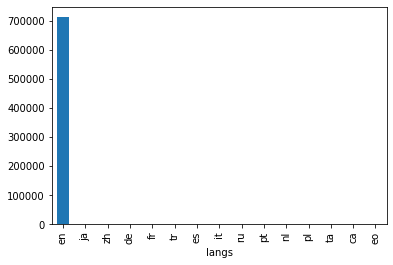

In [63]:
df_langs.head(15).plot.bar()

In [56]:
df_NLP[df_NLP['langs'] == 'ja']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-10-07 16:28:09,q3ct6l,Tilray,Tilray 142🚀🚀🚀🦍🦍🦍let’s go,[Tilray],"[Tilray, 142🚀🚀🚀🦍🦍🦍let us, go]",Tilray,Tilray 142🚀🚀🚀🦍🦍🦍let us go,ja
2021-09-24 15:01:40,pulmly,$WISH,$WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH ...,[$WISH],"[$WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WISH, $WIS...",$WISH,$WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH $WISH ...,ja
2021-09-07 13:49:17,pjnfak,DOLLAR TREE (DLTR),"DOLLAR TREE \n\nQ2 2021: \n\nEPS **1,23**$ (+11,8% VS Q2 2020, + 62% VS Q2 2019)\n\nSALES Q2 20...","[DOLLAR, TREE, (DLTR)]","[DOLLAR, TREE, Q2, 2021:, EPS, **1,23**$, (+11,8%, VS, Q2, 2020,, +, 62%, VS, Q2, 2019), SALES, ...",DOLLAR TREE (DLTR),"DOLLAR TREE Q2 2021: EPS **1,23**$ (+11,8% VS Q2 2020, + 62% VS Q2 2019) SALES Q2 2021 **6,34** ...",ja
2021-08-03 18:46:55,oxa0pm,ATTENTION GREAT DD AMAZING MONEY OPPORTUNITY,MANY LINE MAKE SHOW CRAYON DIRECTION POTENTIAL IMMEDIATE BOOM BREAKOUT AMAZE. AUTISM MOON. THI...,"[ATTENTION, GREAT, DD, AMAZING, MONEY, OPPORTUNITY]","[MANY, LINE, MAKE, SHOW, CRAYON, DIRECTION, POTENTIAL, IMMEDIATE, BOOM, BREAKOUT, AMAZE., AUTISM...",ATTENTION GREAT DD AMAZING MONEY OPPORTUNITY,MANY LINE MAKE SHOW CRAYON DIRECTION POTENTIAL IMMEDIATE BOOM BREAKOUT AMAZE. AUTISM MOON. THIS ...,ja
2021-08-02 17:48:48,owjs3q,IS IT CLOVER TIME?,4 LEAF CLOVERS?,"[IS, IT, CLOVER, TIME?]","[4, LEAF, CLOVERS?]",IS IT CLOVER TIME?,4 LEAF CLOVERS?,ja
...,...,...,...,...,...,...,...,...
2020-05-24 18:25:26,gpum4c,Workers Shut down line at Ford Dearborn Plant,LET MY FORD PUTS PRINT,"[Workers, Shut, down, line, at, Ford, Dearborn, Plant]","[LET, MY, FORD, PUTS, PRINT]",Workers Shut down line at Ford Dearborn Plant,LET MY FORD PUTS PRINT,ja
2020-05-21 10:54:43,gnup87,"I have $5K I earned from my quarterly bonus today. Whatever the top comment on this post is, Ill...","/﹋\. \n(҂`_´) \n&lt;,︻╦╤─ ҉ - -. $5K\n\n/﹋\","[I, have, $5K, I, earned, from, my, quarterly, bonus, today., Whatever, the, top, comment, on, t...","[/﹋\., (҂`_´), &lt;,︻╦╤─, ҉, -, -., $5K, /﹋\]","I have $5K I earned from my quarterly bonus today. Whatever the top comment on this post is, Ill...","/﹋\. (҂`_´) &lt;,︻╦╤─ ҉ - -. $5K /﹋\",ja
2020-05-18 14:40:58,gm2o36,RIGGED STOCK MARKET,$SPY\n\nMONDAY- GREEN\n\nTUESDAY- RED\n\nWEDNESDAY- RED\n\nTHURSDAY- GREEN (IF UNEMPLOYMENT IS H...,"[RIGGED, STOCK, MARKET]","[$SPY, MONDAY-, GREEN, TUESDAY-, RED, WEDNESDAY-, RED, THURSDAY-, GREEN, (IF, UNEMPLOYMENT, IS, ...",RIGGED STOCK MARKET,$SPY MONDAY- GREEN TUESDAY- RED WEDNESDAY- RED THURSDAY- GREEN (IF UNEMPLOYMENT IS HIGH) FRIDAY-...,ja


### It can be seen that even though selftext of some submissions was classified as japanese langauge it is not the case.

In [57]:
df_NLP[df_NLP['langs'] == 'zh']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-10-07 22:30:25,q3kcc9,PBTS 43% short float,SQUEEEEEEEEZE IT \n\n\n[https://elite.finviz.com/quote.ashx?t=PBTS&amp;ty=c&amp;p=d&amp;b=1](ht...,"[PBTS, 43%, short, float]","[SQUEEEEEEEEZE, IT, [https://elite.finviz.com/quote.ashx?t=PBTS&amp;ty=c&amp;p=d&amp;b=1](https:...",PBTS 43% short float,SQUEEEEEEEEZE IT [https://elite.finviz.com/quote.ashx?t=PBTS&amp;ty=c&amp;p=d&amp;b=1](https://e...,zh
2021-08-20 06:23:11,p7wjxy,今日重点新闻看过来！🗞 (Only Malaysian Trader),👉FREIGHT 2021财政年last quarter net profit 按年飙涨671.94%\n\n👉NESTCON 接获 MMCCORP 颁发的分包工程合约，总值 RM33.65 ...,"[今日重点新闻看过来！🗞, (Only, Malaysian, Trader)]","[👉FREIGHT, 2021财政年last, quarter, net, profit, 按年飙涨671.94%, 👉NESTCON, 接获, MMCCORP, 颁发的分包工程合约，总值, ...",今日重点新闻看过来！🗞 (Only Malaysian Trader),👉FREIGHT 2021财政年last quarter net profit 按年飙涨671.94% 👉NESTCON 接获 MMCCORP 颁发的分包工程合约，总值 RM33.65 mil...,zh
2021-08-05 14:22:24,oyj339,Are Etsy shares are good buy today ? 🧐🧐,🤔,"[Are, Etsy, shares, are, good, buy, today, ?, 🧐🧐]",[🤔],Are Etsy shares are good buy today ? 🧐🧐,🤔,zh
2021-08-05 14:22:07,oyj2ig,Are Etsy shares are good buy today ? 🧐🧐,🤔,"[Are, Etsy, shares, are, good, buy, today, ?, 🧐🧐]",[🤔],Are Etsy shares are good buy today ? 🧐🧐,🤔,zh
2021-07-12 17:36:48,oiw76g,Need the help of Apes! This is one of the most shorted stocks out there. Price manipulation by s...,💎😘💎,"[Need, the, help, of, Apes!, This, is, one, of, the, most, shorted, stocks, out, there., Price, ...",[💎😘💎],Need the help of Apes! This is one of the most shorted stocks out there. Price manipulation by s...,💎😘💎,zh
...,...,...,...,...,...,...,...,...
2020-08-24 19:33:30,ifw0o7,"Buying $SLV ""Dips"" for the 4th Time in a Week",&amp;#x200B;\n\n![video](nzk1zliu50j51),"[Buying, $SLV, ""Dips"", for, the, 4th, Time, in, a, Week]","[&amp;#x200B;, ![video](nzk1zliu50j51)]","Buying $SLV ""Dips"" for the 4th Time in a Week",&amp;#x200B; ![video](nzk1zliu50j51),zh
2020-05-29 12:32:52,gss5bz,Spending down 13%. Numbers this low haven’t been seen since 100 years /CNBC,😬😬,"[Spending, down, 13%., Numbers, this, low, have not, been, seen, since, 100, years, /CNBC]",[😬😬],Spending down 13%. Numbers this low have not been seen since 100 years /CNBC,😬😬,zh
2020-05-28 04:17:11,grza0c,EZ 1 Million Tendies,NLY 7$ 6/5 CALL,"[EZ, 1, Million, Tendies]","[NLY, 7$, 6/5, CALL]",EZ 1 Million Tendies,NLY 7$ 6/5 CALL,zh


In [58]:
df_NLP[df_NLP['langs'] == 'fr']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-10-16 18:18:36,q9hgr2,Air Canada yolo,"Bought $70K @ $26.40 just to watch it drop the last couple fo weeks, but expecting $30 by Dec an...","[Air, Canada, yolo]","[Bought, $70K, @, $26.40, just, to, watch, it, drop, the, last, couple, fo, weeks,, but, expecti...",Air Canada yolo,"Bought $70K @ $26.40 just to watch it drop the last couple fo weeks, but expecting $30 by Dec an...",fr
2021-06-23 16:50:00,o6gslb,RKT Set to Explode,[https://youtu.be/BlOJJt8a-jg](https://youtu.be/BlOJJt8a-jg),"[RKT, Set, to, Explode]",[[https://youtu.be/BlOJJt8a-jg](https://youtu.be/BlOJJt8a-jg)],RKT Set to Explode,[https://youtu.be/BlOJJt8a-jg](https://youtu.be/BlOJJt8a-jg),fr
2021-06-08 23:47:27,nvi342,who got beef going METTA WORLD BEEF on WENDYS!!,99$,"[who, got, beef, going, METTA, WORLD, BEEF, on, WENDYS!!]",[99$],who got beef going METTA WORLD BEEF on WENDYS!!,99$,fr
2021-06-08 21:30:20,nvf2qc,vacq?,vacq,[vacq?],[vacq],vacq?,vacq,fr
2021-06-08 21:28:40,nvf199,$VIRX 🚀,$VIRX 🚀,"[$VIRX, 🚀]","[$VIRX, 🚀]",$VIRX 🚀,$VIRX 🚀,fr
...,...,...,...,...,...,...,...,...
2020-05-22 13:36:19,gojh6y,Bought bidu and jd puts yesterday 💦💦💦,🌈🌈🐻🏳️‍🌈🏳️‍🌈,"[Bought, bidu, and, jd, puts, yesterday, 💦💦💦]",[🌈🌈🐻🏳️‍🌈🏳️‍🌈],Bought bidu and jd puts yesterday 💦💦💦,🌈🌈🐻🏳️‍🌈🏳️‍🌈,fr
2020-05-15 03:20:01,gk1g6k,Fuck all of you voting. Leave it to the mods.,Fuck you votebot.,"[Fuck, all, of, you, voting., Leave, it, to, the, mods.]","[Fuck, you, votebot.]",Fuck all of you voting. Leave it to the mods.,Fuck you votebot.,fr
2020-05-04 17:23:05,gdftlk,FB gonna drop big soon,.,"[FB, going to, drop, big, soon]",[.],FB going to drop big soon,.,fr


In [59]:
df_NLP[df_NLP['langs'] == 'de']

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs
created_utc,,,,,,,,
2021-10-14 07:30:34,q7urx4,Plug Power,"Öl Giganten Werden bald sich schlagen um Plug Power , denn in Paar Jahre Werde so wenig Öl verka...","[Plug, Power]","[Öl, Giganten, Werden, bald, sich, schlagen, um, Plug, Power, ,, denn, in, Paar, Jahre, Werde, s...",Plug Power,"Öl Giganten Werden bald sich schlagen um Plug Power , denn in Paar Jahre Werde so wenig Öl verka...",de
2021-10-07 15:57:57,q3c5zp,Crashindikatoren,"Hallo zusammen, \n\nich suche gerade verschiedene Indikatoren, die auf eine mögliche stärkere Ko...",[Crashindikatoren],"[Hallo, zusammen,, ich, suche, gerade, verschiedene, Indikatoren,, die, auf, eine, mögliche, stä...",Crashindikatoren,"Hallo zusammen, ich suche gerade verschiedene Indikatoren, die auf eine mögliche stärkere Korrek...",de
2021-10-01 19:28:17,pzf96v,"LCID is gaining traction in Europe, very positive News article in Germany comparing LCID to TSLA...",[Aktien: Lucid besser als Tesla - 01.10.2021 (wallstreet-online.de)](https://www.wallstreet-onl...,"[LCID, is, gaining, traction, in, Europe,, very, positive, News, article, in, Germany, comparing...","[[Aktien:, Lucid, besser, als, Tesla, -, 01.10.2021, (wallstreet-online.de)](https://www.wallstr...","LCID is gaining traction in Europe, very positive News article in Germany comparing LCID to TSLA...",[Aktien: Lucid besser als Tesla - 01.10.2021 (wallstreet-online.de)](https://www.wallstreet-onli...,de
2021-09-18 17:54:26,pqr4za,test,testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttest...,[test],[testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttes...,test,testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttest...,de
2021-09-18 17:53:19,pqr49l,test,testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttest...,[test],[testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttes...,test,testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttest...,de
...,...,...,...,...,...,...,...,...
2020-06-22 04:06:03,hdkxir,$1.1Trillion in assets just joined the 🌈🐻's,"# Bye bye july spy\n\nxoxo\n\n![img](osdrcybgyd651 ""\nDer Bot sagt, mein Beitrag ist zu kurz"")","[$1.1Trillion, in, assets, just, joined, the, 🌈🐻's]","[#, Bye, bye, july, spy, xoxo, ![img](osdrcybgyd651, "", Der, Bot, sagt,, mein, Beitrag, ist, zu,...",$1.1Trillion in assets just joined the 🌈🐻's,"# Bye bye july spy xoxo ![img](osdrcybgyd651 "" Der Bot sagt, mein Beitrag ist zu kurz"")",de
2020-06-16 02:11:37,h9ucxi,DD,00110000 00110001 00110001 00110000 00110000 00110001 00110000 00110001 00100000 00110000 001100...,[DD],"[00110000, 00110001, 00110001, 00110000, 00110000, 00110001, 00110000, 00110001, 00100000, 00110...",DD,00110000 00110001 00110001 00110000 00110000 00110001 00110000 00110001 00100000 00110000 001100...,de
2020-06-07 01:37:08,gy3gwx,Am I shadow banned wow,Wtf mods,"[Am, I, shadow, banned, wow]","[Wtf, mods]",Am I shadow banned wow,Wtf mods,de


In [64]:
# remove non english submissions 
df_NLP = df_NLP[df_NLP['langs'] == 'en']

## 1.3 Converting all Characters to Lowercase, Tokenization, Removing Punctuations

In [66]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [68]:
df_NLP['title_tokenized'] = df_NLP['title_str'].apply(word_tokenize)
df_NLP['selftext_tokenized'] = df_NLP['selfttext_str'].apply(word_tokenize)


In [69]:
punc = string.punctuation
df_NLP['title_tokenized']  = df_NLP['title_tokenized'].apply(lambda x: [word.lower() for word in x])
df_NLP['title_tokenized']  = df_NLP['title_tokenized'].apply(lambda x: [word for word in x if word not in punc])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word.lower() for word in x])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word for word in x if word not in punc])

In [70]:
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized
created_utc,,,,,,,,,,
2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,[BB],"[So, 13.56, cad, for, BB., it is, moving, and, gaining, traction., Get, your, ape, brains, movin...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,[bb],"[so, 13.56, cad, for, bb, it, is, moving, and, gaining, traction, get, your, ape, brains, moving..."
2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,,"[Surely, it, is, a, coincidence.]",[],Surely it is a coincidence.,,en,"[surely, it, is, a, coincidence]",[]
2021-10-19 17:55:24,qbgyco,yolo sava options,,"[yolo, sava, options]",[],yolo sava options,,en,"[yolo, sava, options]",[]
2021-10-19 17:54:51,qbgxy8,meme,,[meme],[],meme,,en,[meme],[]
2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",[BB],"[BB, is, on, the, move, higher,, not, because, of, the, patent, alone,, but, because, of, what i...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,[bb],"[bb, is, on, the, move, higher, not, because, of, the, patent, alone, but, because, of, what, is..."


## 1.4 Removing Stopwords 

In [72]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [73]:
stop_words = set(stopwords.words('english'))
df_NLP['title_tokenized'] = df_NLP['title_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df_NLP['selftext_tokenized'] = df_NLP['selftext_tokenized'].apply(lambda x: [word for word in x if word not in stop_words])


In [74]:
df_NLP.head(10)

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized
created_utc,,,,,,,,,,
2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,[BB],"[So, 13.56, cad, for, BB., it is, moving, and, gaining, traction., Get, your, ape, brains, movin...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,[bb],"[13.56, cad, bb, moving, gaining, traction, get, ape, brains, moving, one, late, buy, black, ber..."
2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,,"[Surely, it, is, a, coincidence.]",[],Surely it is a coincidence.,,en,"[surely, coincidence]",[]
2021-10-19 17:55:24,qbgyco,yolo sava options,,"[yolo, sava, options]",[],yolo sava options,,en,"[yolo, sava, options]",[]
2021-10-19 17:54:51,qbgxy8,meme,,[meme],[],meme,,en,[meme],[]
2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",[BB],"[BB, is, on, the, move, higher,, not, because, of, the, patent, alone,, but, because, of, what i...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,[bb],"[bb, move, higher, patent, alone, coming, pipelines, holder, stock, also, strong, believer, 1000..."
2021-10-19 17:51:29,qbgvh0,SDIG,,[SDIG],[],SDIG,,en,[sdig],[]
2021-10-19 17:50:55,qbgv2y,A Sitting Ape Is strong against a charging Bull,,"[A, Sitting, Ape, Is, strong, against, a, charging, Bull]",[],A Sitting Ape Is strong against a charging Bull,,en,"[sitting, ape, strong, charging, bull]",[]
2021-10-19 17:47:50,qbgspe,Is this the inspiration,,"[Is, this, the, inspiration]",[],Is this the inspiration,,en,[inspiration],[]
2021-10-19 17:46:50,qbgs0r,PROG YOLO 1.5 yrs out,,"[PROG, YOLO, 1.5, yrs, out]",[],PROG YOLO 1.5 yrs out,,en,"[prog, yolo, 1.5, yrs]",[]


## 1.4 Lemmatization

In [76]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [77]:
df_NLP['pos_tags_title'] = df_NLP['title_tokenized'].apply(nltk.tag.pos_tag)
df_NLP['pos_tags_selftext'] = df_NLP['selftext_tokenized'].apply(nltk.tag.pos_tag)


In [82]:
%who_ls DataFrame 

['df_NLP', 'df_submissions']

In [79]:
df_NLP.head()

,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext
created_utc,,,,,,,,,,,,
2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,[BB],"[So, 13.56, cad, for, BB., it is, moving, and, gaining, traction., Get, your, ape, brains, movin...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,[bb],"[13.56, cad, bb, moving, gaining, traction, get, ape, brains, moving, one, late, buy, black, ber...","[(bb, NN)]","[(13.56, CD), (cad, NN), (bb, NN), (moving, VBG), (gaining, VBG), (traction, NN), (get, VB), (ap..."
2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,,"[Surely, it, is, a, coincidence.]",[],Surely it is a coincidence.,,en,"[surely, coincidence]",[],"[(surely, RB), (coincidence, NN)]",[]
2021-10-19 17:55:24,qbgyco,yolo sava options,,"[yolo, sava, options]",[],yolo sava options,,en,"[yolo, sava, options]",[],"[(yolo, RB), (sava, NN), (options, NNS)]",[]
2021-10-19 17:54:51,qbgxy8,meme,,[meme],[],meme,,en,[meme],[],"[(meme, NN)]",[]
2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",[BB],"[BB, is, on, the, move, higher,, not, because, of, the, patent, alone,, but, because, of, what i...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,[bb],"[bb, move, higher, patent, alone, coming, pipelines, holder, stock, also, strong, believer, 1000...","[(bb, NN)]","[(bb, RB), (move, NN), (higher, RBR), (patent, NN), (alone, RB), (coming, VBG), (pipelines, NNS)..."


In [83]:
df_NLP.to_csv('/content/drive/MyDrive/WSB/wsb_submissions_clean.csv')

In [2]:
submissions = "/content/drive/MyDrive/WSB/wsb_submissions_clean.csv"
df_submissions = pd.read_csv(submissions)
df_submissions.head(10)

,created_utc,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext
0,2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,['BB'],"['So', '13.56', 'cad', 'for', 'BB.', 'it is', 'moving', 'and', 'gaining', 'traction.', 'Get', 'y...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,['bb'],"['13.56', 'cad', 'bb', 'moving', 'gaining', 'traction', 'get', 'ape', 'brains', 'moving', 'one',...","[('bb', 'NN')]","[('13.56', 'CD'), ('cad', 'NN'), ('bb', 'NN'), ('moving', 'VBG'), ('gaining', 'VBG'), ('traction..."
1,2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,NaN,"['Surely', 'it', 'is', 'a', 'coincidence.']",[],Surely it is a coincidence.,NaN,en,"['surely', 'coincidence']",[],"[('surely', 'RB'), ('coincidence', 'NN')]",[]
2,2021-10-19 17:55:24,qbgyco,yolo sava options,NaN,"['yolo', 'sava', 'options']",[],yolo sava options,NaN,en,"['yolo', 'sava', 'options']",[],"[('yolo', 'RB'), ('sava', 'NN'), ('options', 'NNS')]",[]
3,2021-10-19 17:54:51,qbgxy8,meme,NaN,['meme'],[],meme,NaN,en,['meme'],[],"[('meme', 'NN')]",[]
4,2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",['BB'],"['BB', 'is', 'on', 'the', 'move', 'higher,', 'not', 'because', 'of', 'the', 'patent', 'alone,', ...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,['bb'],"['bb', 'move', 'higher', 'patent', 'alone', 'coming', 'pipelines', 'holder', 'stock', 'also', 's...","[('bb', 'NN')]","[('bb', 'RB'), ('move', 'NN'), ('higher', 'RBR'), ('patent', 'NN'), ('alone', 'RB'), ('coming', ..."
5,2021-10-19 17:51:29,qbgvh0,SDIG,NaN,['SDIG'],[],SDIG,NaN,en,['sdig'],[],"[('sdig', 'NN')]",[]
6,2021-10-19 17:50:55,qbgv2y,A Sitting Ape Is strong against a charging Bull,NaN,"['A', 'Sitting', 'Ape', 'Is', 'strong', 'against', 'a', 'charging', 'Bull']",[],A Sitting Ape Is strong against a charging Bull,NaN,en,"['sitting', 'ape', 'strong', 'charging', 'bull']",[],"[('sitting', 'VBG'), ('ape', 'NN'), ('strong', 'JJ'), ('charging', 'NN'), ('bull', 'NN')]",[]
7,2021-10-19 17:47:50,qbgspe,Is this the inspiration,NaN,"['Is', 'this', 'the', 'inspiration']",[],Is this the inspiration,NaN,en,['inspiration'],[],"[('inspiration', 'NN')]",[]
8,2021-10-19 17:46:50,qbgs0r,PROG YOLO 1.5 yrs out,NaN,"['PROG', 'YOLO', '1.5', 'yrs', 'out']",[],PROG YOLO 1.5 yrs out,NaN,en,"['prog', 'yolo', '1.5', 'yrs']",[],"[('prog', 'NN'), ('yolo', 'CC'), ('1.5', 'CD'), ('yrs', 'NN')]",[]
9,2021-10-19 17:46:46,qbgrz6,Don't Be A Menace To Hedge Funds By Squeezing Their Shorts of $HOOD,"What up, nerds? Long time no post. I come bearing gifts of knowledge. Whatever you do with that ...","['do not', 'Be', 'A', 'Menace', 'To', 'Hedge', 'Funds', 'By', 'Squeezing', 'Their', 'Shorts', 'o...","['What', 'up,', 'nerds?', 'Long', 'time', 'no', 'post.', 'I', 'come', 'bearing', 'gifts', 'of', ...",do not Be A Menace To Hedge Funds By Squeezing Their Shorts of $HOOD,"What up, nerds? Long time no post. I come bearing gifts of knowledge. Whatever you do with that ...",en,"['menace', 'hedge', 'funds', 'squeezing', 'shorts', 'hood']","['nerds', 'long', 'time', 'post', 'come', 'bearing', 'gifts', 'knowledge', 'whatever', 'knowledg...","[('menace', 'NN'), ('hedge', 'NN'), ('funds', 'NNS'), ('squeezing', 'VBG'), ('shorts', 'NNS'), (...","[('nerds', 'NNS'), ('long', 'JJ'), ('time', 'NN'), ('post', 'NN'), ('come', 'VB'), ('bearing', '..."


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
d =[('menace', 'NN'), ('hedge', 'NN'), ('funds', 'NNS'), ('squeezing', 'VBG'), ('shorts', 'NNS')]
print(type(d))	
for index, tuple in enumerate(d):
    print(tuple[0], tuple[1])

for (word, pos_tag) in d:
    print(type((word, pos_tag)))
    print(word,pos_tag)
   

<class 'list'>
menace NN
hedge NN
funds NNS
squeezing VBG
shorts NNS
<class 'tuple'>
menace NN
<class 'tuple'>
hedge NN
<class 'tuple'>
funds NNS
<class 'tuple'>
squeezing VBG
<class 'tuple'>
shorts NNS


In [19]:
import json


In [20]:
test=df_submissions.loc[0:10,'pos_tags_title'].apply(lambda x: [word for word in eval(x)])


In [21]:
test[0]

[('bb', 'NN')]

In [25]:
def get_wordnet_pos(tag):    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df_submissions['title_wordnet_pos'] = df_submissions['pos_tags_title'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in eval(x)])
df_submissions['selftext_wordnet_pos'] = df_submissions['pos_tags_selftext'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in eval(x)])
df_submissions.head()

,created_utc,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext,title_wordnet_pos,selftext_wordnet_pos
0,2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,['BB'],"['So', '13.56', 'cad', 'for', 'BB.', 'it is', 'moving', 'and', 'gaining', 'traction.', 'Get', 'y...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,['bb'],"['13.56', 'cad', 'bb', 'moving', 'gaining', 'traction', 'get', 'ape', 'brains', 'moving', 'one',...","[('bb', 'NN')]","[('13.56', 'CD'), ('cad', 'NN'), ('bb', 'NN'), ('moving', 'VBG'), ('gaining', 'VBG'), ('traction...","[(bb, n)]","[(13.56, n), (cad, n), (bb, n), (moving, v), (gaining, v), (traction, n), (get, v), (ape, n), (b..."
1,2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,NaN,"['Surely', 'it', 'is', 'a', 'coincidence.']",[],Surely it is a coincidence.,NaN,en,"['surely', 'coincidence']",[],"[('surely', 'RB'), ('coincidence', 'NN')]",[],"[(surely, r), (coincidence, n)]",[]
2,2021-10-19 17:55:24,qbgyco,yolo sava options,NaN,"['yolo', 'sava', 'options']",[],yolo sava options,NaN,en,"['yolo', 'sava', 'options']",[],"[('yolo', 'RB'), ('sava', 'NN'), ('options', 'NNS')]",[],"[(yolo, r), (sava, n), (options, n)]",[]
3,2021-10-19 17:54:51,qbgxy8,meme,NaN,['meme'],[],meme,NaN,en,['meme'],[],"[('meme', 'NN')]",[],"[(meme, n)]",[]
4,2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",['BB'],"['BB', 'is', 'on', 'the', 'move', 'higher,', 'not', 'because', 'of', 'the', 'patent', 'alone,', ...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,['bb'],"['bb', 'move', 'higher', 'patent', 'alone', 'coming', 'pipelines', 'holder', 'stock', 'also', 's...","[('bb', 'NN')]","[('bb', 'RB'), ('move', 'NN'), ('higher', 'RBR'), ('patent', 'NN'), ('alone', 'RB'), ('coming', ...","[(bb, n)]","[(bb, r), (move, n), (higher, r), (patent, n), (alone, r), (coming, v), (pipelines, n), (holder,..."


In [26]:
wnl = WordNetLemmatizer()
df_submissions['title_lemmatized'] = df_submissions['title_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_submissions['selftext_lemmatized'] = df_submissions['selftext_wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_submissions.head()

,created_utc,id,title,selftext,title_no_contract,selftext_no_contract,title_str,selfttext_str,langs,title_tokenized,selftext_tokenized,pos_tags_title,pos_tags_selftext,title_wordnet_pos,selftext_wordnet_pos,title_lemmatized,selftext_lemmatized
0,2021-10-19 17:58:57,qbh10s,BB,So 13.56 cad for BB. It’s moving and gaining traction. Get your ape brains moving on this one ...,['BB'],"['So', '13.56', 'cad', 'for', 'BB.', 'it is', 'moving', 'and', 'gaining', 'traction.', 'Get', 'y...",BB,So 13.56 cad for BB. it is moving and gaining traction. Get your ape brains moving on this one b...,en,['bb'],"['13.56', 'cad', 'bb', 'moving', 'gaining', 'traction', 'get', 'ape', 'brains', 'moving', 'one',...","[('bb', 'NN')]","[('13.56', 'CD'), ('cad', 'NN'), ('bb', 'NN'), ('moving', 'VBG'), ('gaining', 'VBG'), ('traction...","[(bb, n)]","[(13.56, n), (cad, n), (bb, n), (moving, v), (gaining, v), (traction, n), (get, v), (ape, n), (b...",[bb],"[13.56, cad, bb, move, gain, traction, get, ape, brain, move, one, late, buy, black, berry, make..."
1,2021-10-19 17:57:49,qbh04w,Surely it is a coincidence.,NaN,"['Surely', 'it', 'is', 'a', 'coincidence.']",[],Surely it is a coincidence.,NaN,en,"['surely', 'coincidence']",[],"[('surely', 'RB'), ('coincidence', 'NN')]",[],"[(surely, r), (coincidence, n)]",[],"[surely, coincidence]",[]
2,2021-10-19 17:55:24,qbgyco,yolo sava options,NaN,"['yolo', 'sava', 'options']",[],yolo sava options,NaN,en,"['yolo', 'sava', 'options']",[],"[('yolo', 'RB'), ('sava', 'NN'), ('options', 'NNS')]",[],"[(yolo, r), (sava, n), (options, n)]",[],"[yolo, sava, option]",[]
3,2021-10-19 17:54:51,qbgxy8,meme,NaN,['meme'],[],meme,NaN,en,['meme'],[],"[('meme', 'NN')]",[],"[(meme, n)]",[],[meme],[]
4,2021-10-19 17:52:33,qbgw9u,BB,"BB is on the move higher, not because of the patent alone, but because of what's coming in the p...",['BB'],"['BB', 'is', 'on', 'the', 'move', 'higher,', 'not', 'because', 'of', 'the', 'patent', 'alone,', ...",BB,"BB is on the move higher, not because of the patent alone, but because of what is coming in the ...",en,['bb'],"['bb', 'move', 'higher', 'patent', 'alone', 'coming', 'pipelines', 'holder', 'stock', 'also', 's...","[('bb', 'NN')]","[('bb', 'RB'), ('move', 'NN'), ('higher', 'RBR'), ('patent', 'NN'), ('alone', 'RB'), ('coming', ...","[(bb, n)]","[(bb, r), (move, n), (higher, r), (patent, n), (alone, r), (coming, v), (pipelines, n), (holder,...",[bb],"[bb, move, higher, patent, alone, come, pipeline, holder, stock, also, strong, believer, 1000, s..."


In [27]:
df_submissions.to_csv('/content/drive/MyDrive/WSB/wsb_submissions_NLP.csv')

In [28]:
df_submissions = df_submissions.loc[:,['created_utc','id','title','selftext','title_lemmatized','selftext_lemmatized']]

In [29]:
df_submissions.to_csv('/content/drive/MyDrive/WSB/wsb_submissions_NLP_clean.csv')